## Goals of the project
* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## Import the required packages

In [1]:
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.feature import hog
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

## Loading the vehicle and non-vehicle data

In [2]:
car = glob.glob('vehicles/**/*.png')
noncar = glob.glob('non-vehicles/**/*.png')
print ("No. of car images: ", len(car))
print ("No. of non-car images: ", len(noncar))

('No. of car images: ', 8792)
('No. of non-car images: ', 8968)


## Visualizing the data

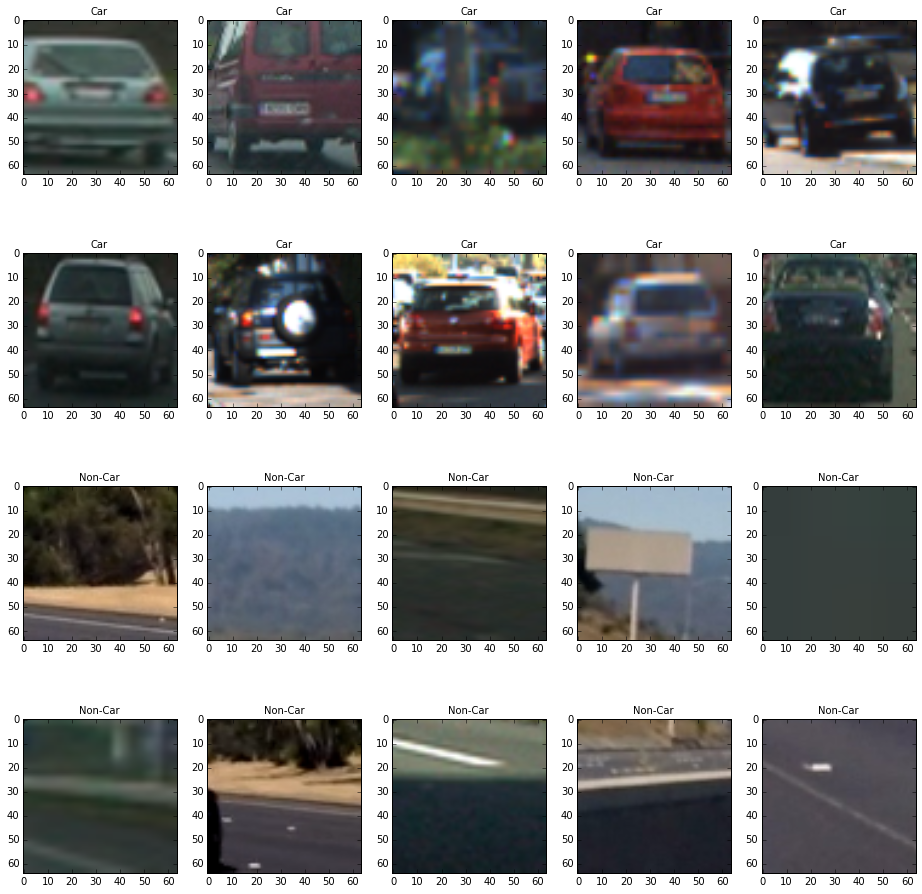

In [3]:
fig, axs = plt.subplots(4,5, figsize=(16, 16))
axs = axs.ravel()

for i in np.arange(10):
    img = cv2.imread(car[np.random.randint(0,len(car))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].set_title('Car', fontsize=10)
    axs[i].imshow(img)
for i in np.arange(10,20):
    img = cv2.imread(noncar[np.random.randint(0,len(noncar))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].set_title('Non-Car', fontsize=10)
    axs[i].imshow(img)
plt.savefig('output_images/sample_images')

## Extracting features
This method was adopted from Udacity lesson "HOG Classify" 

This function extracts Histogram of Oriented Gradients (HOG) features from the image

In [4]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec, )
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Visualise Hog image

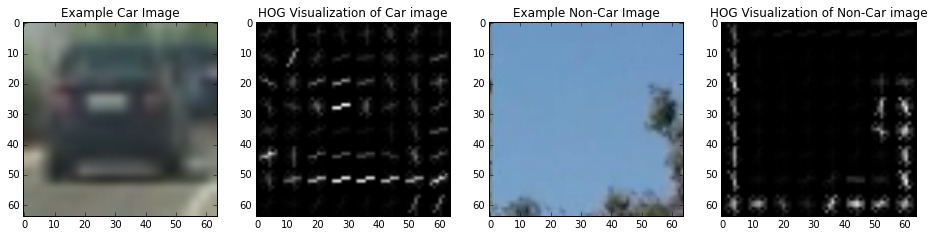

In [5]:
test_image_car = mpimg.imread(car[0])
test_image_noncar = mpimg.imread(noncar[0])

_, car_hog = get_hog_features(test_image_car[:,:,2], 9, 8, 8, vis=True, feature_vec=True)
_, noncar_hog = get_hog_features(test_image_noncar[:,:,2], 9, 8, 8, vis=True, feature_vec=True)

# Plot the examples
fig = plt.figure(figsize=(16, 16))
plt.subplot(141)
plt.imshow(test_image_car, cmap='gray')
plt.title('Example Car Image')
plt.subplot(142)
plt.imshow(car_hog, cmap='gray')
plt.title('HOG Visualization of Car image')
plt.subplot(143)
plt.imshow(test_image_noncar, cmap='gray')
plt.title('Example Non-Car Image')
plt.subplot(144)
plt.imshow(noncar_hog, cmap='gray')
plt.title('HOG Visualization of Non-Car image')
plt.savefig('output_images/hog_visualization')

## Define a function to compute binned color features 
This method was adopted from Udacity lesson "HOG Classify"

In [6]:
def bin_spatial(img, size=(16, 16)):
    return cv2.resize(img, size).ravel() 

## Define a function to compute color histogram features 
This method was adopted from Udacity lesson "HOG Classify"

In [7]:
def color_hist(img, nbins=32):
    ch1 = np.histogram(img[:,:,0], bins=nbins, range=(0, 256))[0]#We need only the histogram, no bins edges
    ch2 = np.histogram(img[:,:,1], bins=nbins, range=(0, 256))[0]
    ch3 = np.histogram(img[:,:,2], bins=nbins, range=(0, 256))[0]
    hist = np.hstack((ch1, ch2, ch3))
    return hist

## Define a function to extract features from a list of images
This method was adopted from Udacity lesson "HOG Classify"

In [8]:
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCR_CB)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

## Extract the HOG features from the images, create the label vector and shuffle, split the dataset into test and train
This method was adopted from Udacity lesson "Search and Classify"

In [9]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t=time.time()
car_features = extract_features(car, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,hist_bins=hist_bins,
                        hist_feat=hist_feat, hog_feat=hog_feat)
noncar_features = extract_features(noncar, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel,spatial_size=spatial_size,hist_bins=hist_bins,
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, noncar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(noncar_features))))


# Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=21)
#21: 0.9901

(119.93, 'Seconds to extract HOG features...')


### Exploring Parameters

Config 1: 
* colorspace = 'RGB' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (84.15, 'Seconds to extract HOG features...')

Config 2: 
* colorspace = 'HSV' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (90.15, 'Seconds to extract HOG features...')

Config 3: 
* colorspace = 'LUV' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (95.28, 'Seconds to extract HOG features...')

Config 4: 
* colorspace = 'HLS' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (97.36, 'Seconds to extract HOG features...')

Config 5: 
* colorspace = 'YUV'
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (81.51, 'Seconds to extract HOG features...')

Config 6: 
* colorspace = 'YCrCb' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (82.36, 'Seconds to extract HOG features...')

Config 7: 
* colorspace = 'YCrCb' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (51.84, 'Seconds to extract HOG features...')

Config 8: 

* colorspace = 'RGB' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (44.31, 'Seconds to extract HOG features...')

Config 9: 
* colorspace = 'HSV' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (45.17, 'Seconds to extract HOG features...')

Config 10: 
* colorspace = 'LUV' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (46.55, 'Seconds to extract HOG features...')

Config 11: 
* colorspace = 'HLS' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (47.88, 'Seconds to extract HOG features...')

Config 12: 
* colorspace = 'YUV' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (45.31, 'Seconds to extract HOG features...')

Config 13: 
* colorspace = 'YUV' 
* orient = 11
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (51.2, 'Seconds to extract HOG features...')

Config 14: 
* colorspace = 'YUV' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 0 
* (31.38, 'Seconds to extract HOG features...')

## Training Classifier
This method was adopted from Udacity lesson "Search and Classify"

In [10]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

(27.54, 'Seconds to train SVC...')
('Test Accuracy of SVC = ', 0.9901)
('My SVC predicts: ', array([ 0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.]))
('For these', 10, 'labels: ', array([ 0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.]))
(0.00132, 'Seconds to predict', 10, 'labels with SVC')


### Exploring Parameters

Config 1: 
* colorspace = 'RGB' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (21.92, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9752)
* (0.00175, 'Seconds to predict', 10, 'labels with SVC')

Config 2: 
* colorspace = 'HSV' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (19.14, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9900)
* (0.00244, 'Seconds to predict', 10, 'labels with SVC')

Config 3: 
* colorspace = 'LUV' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (19.64, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.987)
* (0.00226, 'Seconds to predict', 10, 'labels with SVC')

Config 4: 
* colorspace = 'HLS' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (19.47, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9899)
* (0.00197, 'Seconds to predict', 10, 'labels with SVC')

Config 5: 
* colorspace = 'YUV'
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (18.37, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9901)
* (0.0021, 'Seconds to predict', 10, 'labels with SVC')

Config 6: 
* colorspace = 'YCrCb' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 'ALL' 
* (17.86, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9789)
* (0.00245, 'Seconds to predict', 10, 'labels with SVC')

Config 7: 
* colorspace = 'YCrCb' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (3.13, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9885)
* (0.0018, 'Seconds to predict', 10, 'labels with SVC')

Config 8: 
* colorspace = 'RGB' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (6.92, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9555)
* (0.0013, 'Seconds to predict', 10, 'labels with SVC')

Config 9: 
* colorspace = 'HSV' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (3.1, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9721)
* (0.00172, 'Seconds to predict', 10, 'labels with SVC')

Config 10: 
* colorspace = 'LUV' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' (4.18, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9628)
* (0.00263, 'Seconds to predict', 10, 'labels with SVC')(46.55, 'Seconds to extract HOG features...')

Config 11: 
* colorspace = 'HLS' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (3.47, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9668)
* (0.00135, 'Seconds to predict', 10, 'labels with SVC')

Config 12: 
* colorspace = 'YUV' 
* orient = 9
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (2.63, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9716)
* (0.00174, 'Seconds to predict', 10, 'labels with SVC')

Config 13: 
* colorspace = 'YUV' 
* orient = 11
* pix_per_cell = 16
* cell_per_block = 2
* hog_channel = 'ALL' 
* (3.05, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9741)
* (0.00162, 'Seconds to predict', 10, 'labels with SVC')

Config 14: 
* colorspace = 'YUV' 
* orient = 9
* pix_per_cell = 8
* cell_per_block = 2
* hog_channel = 0 
* (8.56, 'Seconds to train SVC...')
* ('Test Accuracy of SVC = ', 0.9535)
* (0.00299, 'Seconds to predict', 10, 'labels with SVC')

## Sliding Window search
Define a function that takes an image,start and stop positions in both x and y, window size (x and y dimensions), and overlap fraction (for both x and y)

This method was adopted from Udacity lesson "Search and Classify"


## Function to draw bounding boxes

In [11]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [12]:
def convert_color(img, conv='HSV'):
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCR_CB)
    if conv == 'YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
    if conv == 'LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

In [13]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bboxes = []
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='YUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
    return bboxes

## Testing above function (find_cars()) on the test image

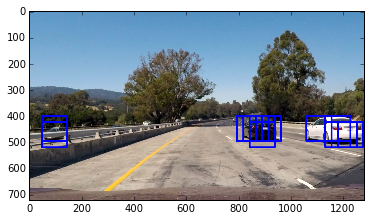

In [14]:
test_img = mpimg.imread('test_images/test1.jpg')

ystart = 400
ystop = 655
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

bboxes = find_cars(test_img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
drawn_image = draw_boxes(test_img, bboxes)
plt.imshow(drawn_image)
plt.savefig('output_images/find_cars')
plt.savefig('output_images/window_15')

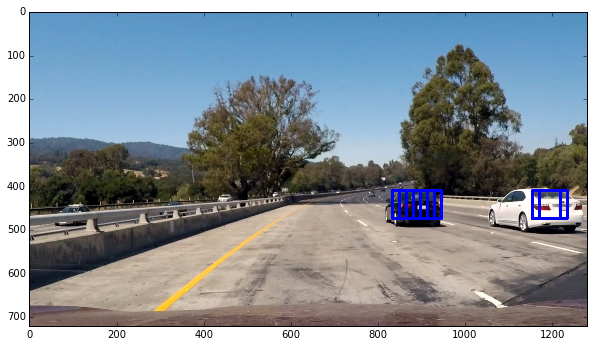

In [15]:
test_img = mpimg.imread('./test_images/test1.jpg')

bboxes = []

ystart = 410
ystop = 510
scale = 1.0
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

bboxes.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

# rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/window_1')

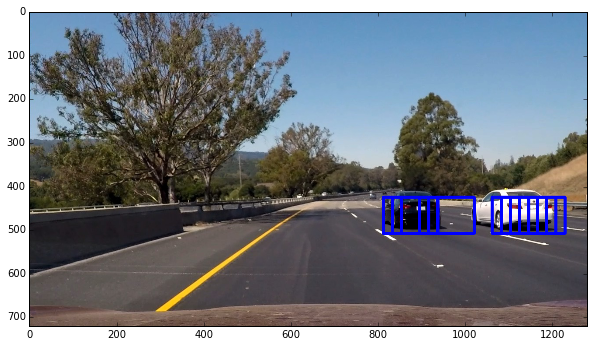

In [16]:
test_img = mpimg.imread('./test_images/test6.jpg')

bboxes = []

ystart = 425
ystop = 520
scale = 1.3
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

bboxes.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

# rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/window_13')

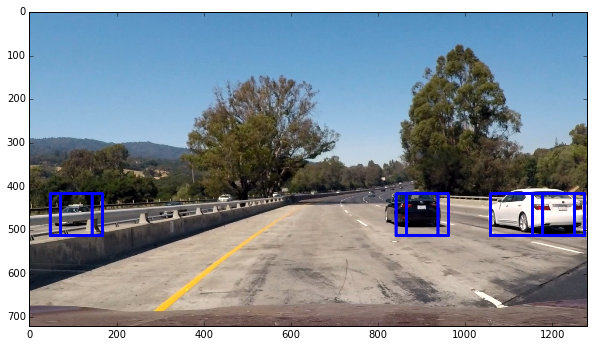

In [38]:
test_img = mpimg.imread('./test_images/test1.jpg')

bboxes = []

ystart = 417
ystop = 530
scale = 1.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

bboxes.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

# rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/window_13_sec')

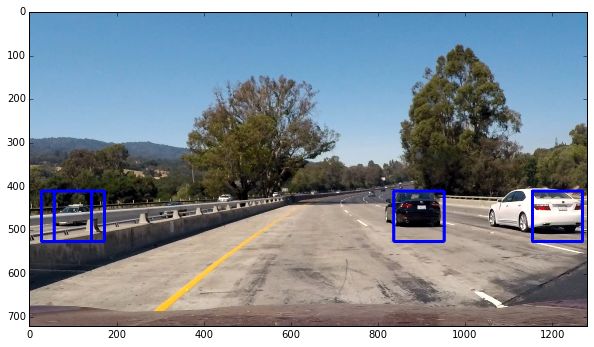

In [18]:
test_img = mpimg.imread('./test_images/test1.jpg')

bboxes = []

ystart = 411
ystop = 531
scale = 1.8
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

bboxes.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

# rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/window_18')

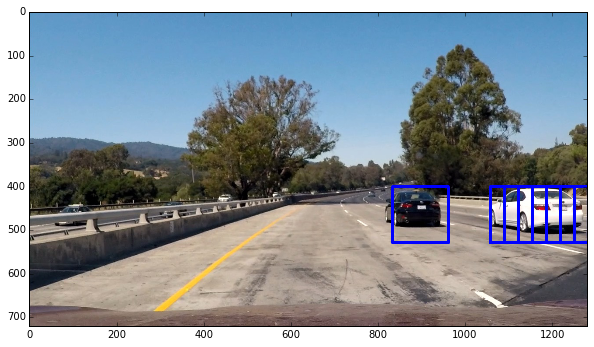

In [19]:
test_img = mpimg.imread('./test_images/test1.jpg')

bboxes = []

ystart = 401
ystop = 540
scale = 2.0
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

bboxes.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

# rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/window_2')

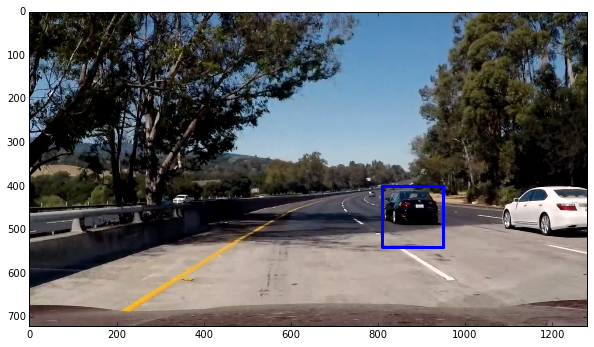

In [20]:
test_img = mpimg.imread('./test_images/test5.jpg')

bboxes = []

ystart = 400
ystop = 550
scale = 2.2
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

bboxes.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

# rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/window_22')

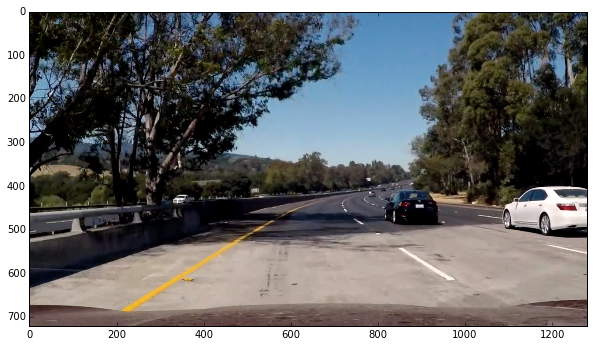

In [21]:
test_img = mpimg.imread('./test_images/test5.jpg')

bboxes = []

ystart = 400
ystop = 575
scale = 2.5
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins

bboxes.extend(find_cars(test_img, ystart, ystop, scale, svc, X_scaler, 
                       orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

# rectangles = [item for sublist in rects for item in sublist] 
test_img_rects = draw_boxes(test_img, bboxes)
plt.figure(figsize=(10,10))
plt.imshow(test_img_rects)
plt.savefig('output_images/window_25')

## Combine sliding window searches

In [22]:
def sliding_window_search(image):
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 9
    pix_per_cell = 8
    cell_per_block = 2
    hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
    spatial_size = (16, 16) # Spatial binning dimensions
    hist_bins = 32    # Number of histogram bins

    bboxes = []

    ystart = 410
    ystop = 510
    scale = 1.0
    bboxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

#     ystart = 420
    ystart = 425
    ystop = 520
    scale = 1.3
    bboxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
#     ystart = 415
    ystart = 417
    ystop = 530
    scale = 1.5
    bboxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 400
#     ystop = 656
    ystop = 655
    scale = 1.5
    bboxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

#     ystart = 407
#     ystop = 530
    ystart = 411
    ystop = 531
    scale = 1.8
    bboxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))
    
#     ystart = 400
    ystart = 401
    ystop = 540
    scale = 2.0
    bboxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 400
    ystop = 550
    scale = 2.2
    bboxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    ystart = 400
    ystop = 575
    scale = 2.5
    bboxes.extend(find_cars(image, ystart, ystop, scale, svc, X_scaler, 
                           orient, pix_per_cell, cell_per_block, spatial_size, hist_bins))

    return bboxes

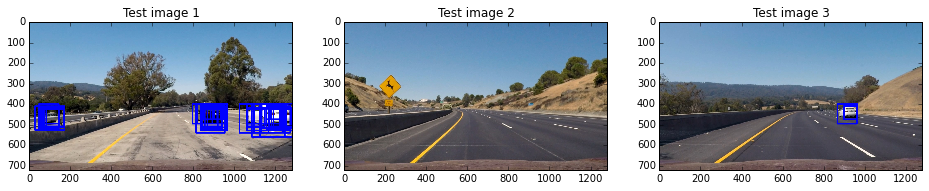

In [23]:
test_images = glob.glob('./test_images/*.jpg')
combined_image = []
# combined_image = mpimg.imread(test_images[1])
# bboxes = sliding_window_search(combined_image)
# drawn_image = draw_boxes(combined_image, bboxes)
# plt.imshow(drawn_image)
for img in test_images:
    combined_img = mpimg.imread(img)
    bboxes = sliding_window_search(combined_img)
    drawn_image = draw_boxes(combined_img, bboxes)
    combined_image.append(drawn_image)
    
# Plot the examples
fig = plt.figure(figsize=(16, 20))
plt.subplot(131)
plt.imshow(combined_image[0])
plt.title('Test image 1')
plt.subplot(132)
plt.imshow(combined_image[1])
plt.title('Test image 2')
plt.subplot(133)
plt.imshow(combined_image[2])
plt.title('Test image 3')
plt.savefig('output_images/combined_box_3')

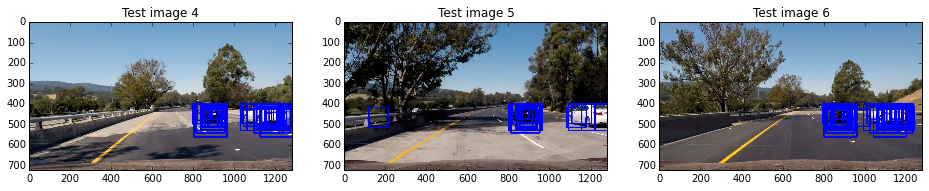

In [24]:
fig = plt.figure(figsize=(16, 20))
plt.subplot(131)
plt.imshow(combined_image[3])
plt.title('Test image 4')
plt.subplot(132)
plt.imshow(combined_image[4])
plt.title('Test image 5')
plt.subplot(133)
plt.imshow(combined_image[5])
plt.title('Test image 6')
plt.savefig('output_images/combined_box_6')

## Creating Heat Map
This method is adopted from Udacity lesson "Multiple Detections and False Positives"

In [25]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

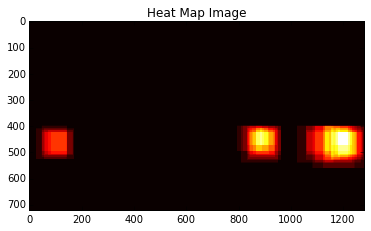

In [26]:
# Testing heatmap on test image
test_image = mpimg.imread('./test_images/test1.jpg')
heat_img = np.zeros_like(test_image[:,:,0]).astype(np.float)
bboxes = sliding_window_search(test_image)
heat_img = add_heat(heat_img, bboxes)
plt.imshow(heat_img, cmap='hot')
plt.title('Heat Map Image')
plt.savefig('output_images/heat')

## Applying Threshold to heatmap to cater false positives and Multiple detections
This method is adopted from Udacity lesson "Multiple Detections and False Positives"

In [27]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

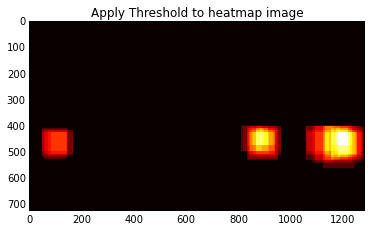

In [28]:
#Testing threshold on test image
heat_img = apply_threshold(heat_img,1)
plt.imshow(heat_img, cmap='hot')
plt.title('Apply Threshold to heatmap image')
plt.savefig('output_images/heat_after_thresh')

## Applying labels to heat map
This method is adopted from Udacity lesson "Multiple Detections and False Positives"

(3, 'cars found')


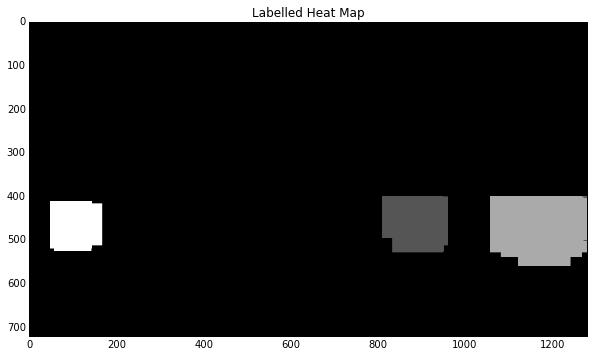

In [29]:
labels = label(heat_img)
plt.figure(figsize=(10,10))
plt.imshow(labels[0], cmap='gray')
plt.title('Labelled Heat Map')
print(labels[1], 'cars found')
plt.savefig('output_images/heat_labelled')

## Draw Bounding Boxes for Labels
This method is adopted from Udacity lesson "Multiple Detections and False Positives"

In [30]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

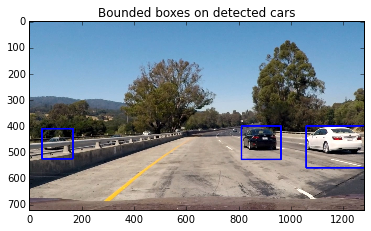

In [31]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
# Display the image
plt.imshow(draw_img)
plt.title('Bounded boxes on detected cars')
plt.savefig('output_images/final_boxes')

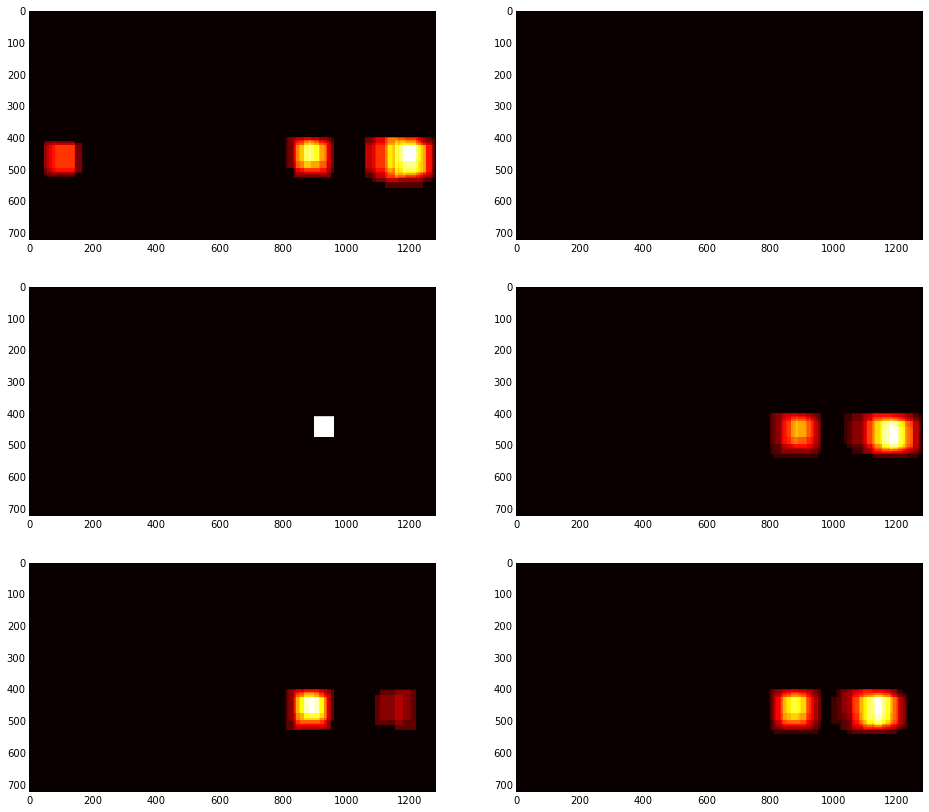

In [42]:
fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()
for i, im in enumerate(test_images):
    img = mpimg.imread(im)
    heat_img = np.zeros_like(img[:,:,0]).astype(np.float)
    bboxes = sliding_window_search(img)
    heat_img = add_heat(heat_img, bboxes)
    axs[i].imshow(apply_threshold(heat_img,1), cmap='hot')
plt.savefig('output_images/heat_all')

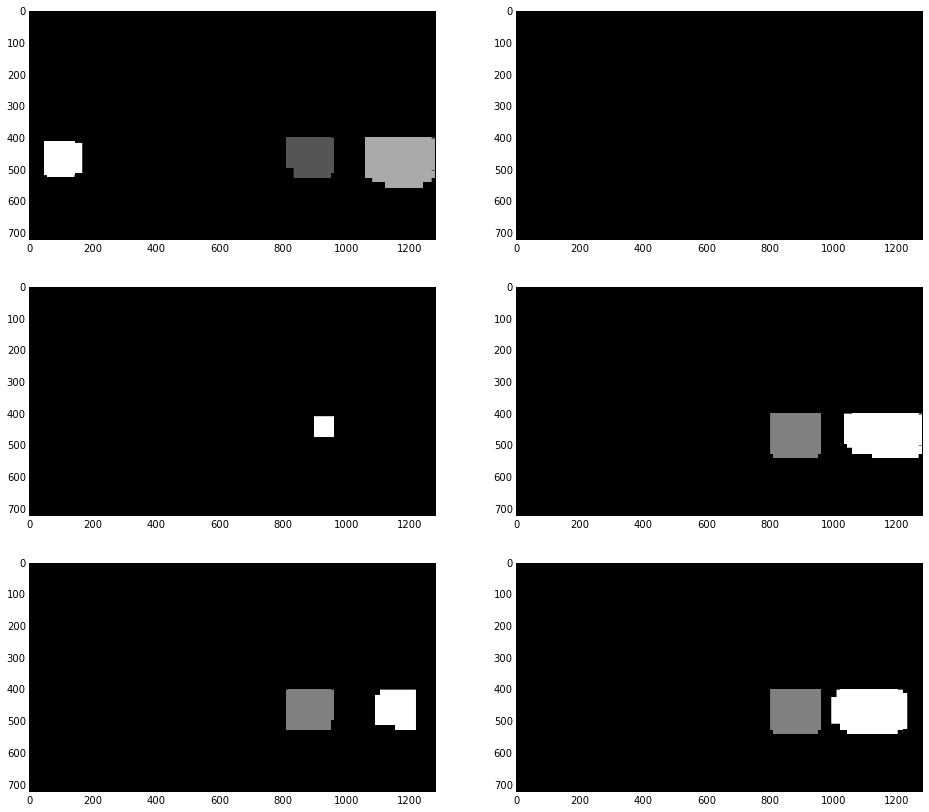

In [47]:
fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()
for i, im in enumerate(test_images):
    img = mpimg.imread(im)
    heat_img = np.zeros_like(img[:,:,0]).astype(np.float)
    bboxes = sliding_window_search(img)
    heat_img = add_heat(heat_img, bboxes)
    heat_img = apply_threshold(heat_img,1)
    axs[i].imshow(label(heat_img)[0], cmap='gray')
plt.savefig('output_images/label_all')

## Entire Process Pipeline

In [32]:
def process(image):
    bboxes = sliding_window_search(image)
    heat_img = np.zeros_like(image[:,:,0]).astype(np.float)
    heat_img = add_heat(heat_img, bboxes)
    heat_img = apply_threshold(heat_img,1.)
    labels = label(heat_img)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img

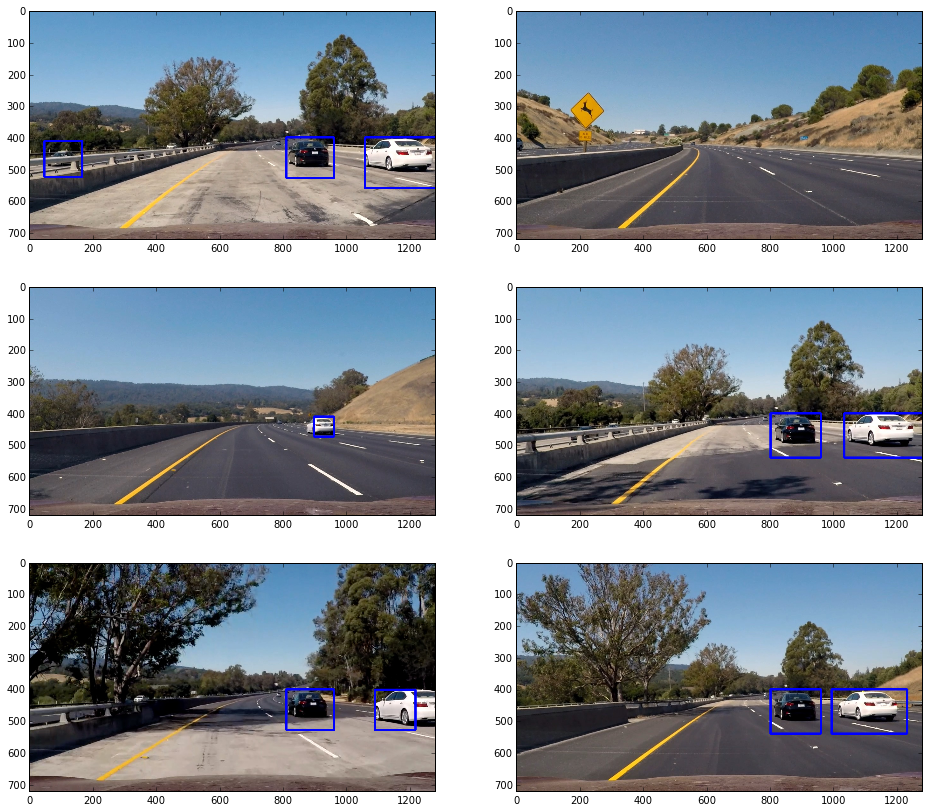

In [33]:
fig, axs = plt.subplots(3, 2, figsize=(16,14))
axs = axs.ravel()
for i, im in enumerate(test_images):
    axs[i].imshow(process(mpimg.imread(im)))
plt.savefig('output_images/final')

In [34]:
test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4


 97%|█████████▋| 38/39 [00:45<00:01,  1.34s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 42.5 s, sys: 2.17 s, total: 44.7 s
Wall time: 47.4 s


In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))

In [36]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [26:10<00:01,  1.17s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 23min 56s, sys: 1min 10s, total: 25min 7s
Wall time: 26min 11s


In [37]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_out_file))